# About the Notebook

### **DATASET** : *Disaster News Classification*

#### **Classifying** FAKE VS REAL NEWS

1. Cleaning the individual rowText : Removing stopwords,urls,@tokens and special attention to #tags.
2. Using Torchtext for integrating the tokenizer(SPACY) and preprocessor.
3. Bucket iterrator is used for grouping similar size of sentences together for minimum padding.
4. Bert Base model for transfer learning.
5. Updating the weights of the last layer of the bert base model.
6. The model is trained and the output is saved in a csv.

[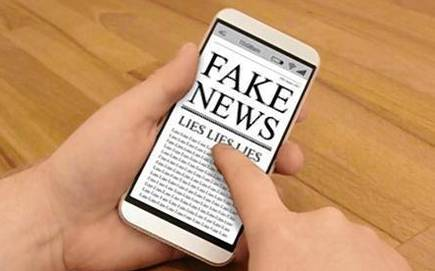](http://)

In [ ]:
# Importing Libraries
import os
import pandas as pd
import string,re
from urllib.parse import urlparse
import spacy
import itertools
from torch import nn
from torchtext import data  
from nltk.corpus import stopwords 
import torch
from torchtext.data import BucketIterator
from torch import nn
from torch.optim import Adam
from matplotlib import pyplot as plt
from torch.backends import cudnn

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
cudnn.benchmark = True

In [ ]:
device

In [ ]:
#DataFrame Options for display
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_rows', None)  
pd.set_option('display.max_colwidth', -1)  

In [ ]:
# loading spacy model
nlp = spacy.load('en_core_web_sm') 

In [ ]:
# Dataset
path  = r'../input/nlp-getting-started/'
trainDataset = pd.read_csv(os.path.join(path,'train.csv'),index_col=0)

## Lets understand the data 

In [ ]:
trainDataset.head(5)

In [ ]:
# The keyword/location column is inconsistent
trainDataset = trainDataset[['text','target']]

In [ ]:
trainDataset.head()

## Cleaning TextColumn

In [ ]:
from unidecode import unidecode
def remove_non_ascii(text):
    return unidecode(text)

In [ ]:
def clean(text):
    # removing the spaces
    text = ' '.join(text.split()) 
    # removing url 
    text = ' '.join([token for token in text.split() if not urlparse(token).scheme]) 
    # removing token starts with @
    text = ' '.join([token for token in text.split() if not (re.match(r'^@',token))])
    # remove all punctuation ( except . and ,)
    text = text.translate(str.maketrans('', '','!"$%&\'()*+-/:;<=>?@[\\]^_`{|}~')) 
    # keep only alphabets
    text = re.sub(r"\d", "", text) 
    text = ' '.join(list(itertools.chain.from_iterable([[s for s in re.split("([A-Z][^A-Z]*)", token.replace('#','')) if s] if (re.match(r'^#',token)) else [token] for token in text.split()])))
    # removing token less than 3 char length and removing non-ascii character
    text = ' '.join([remove_non_ascii(token) for token in text.split()]) 
    text = text.lower().strip()
    return text

####  Check complex logic information extraction of tags

In [ ]:
text = '''#raining #flooding #Florida #TampaBay #Tampa 18 or 19 days. I've lost count'''   

In [ ]:
flatten = [[s for s in re.split("([A-Z][^A-Z]*)", token.replace('#','')) if s] if (re.match(r'^#',token)) else [token] for token in text.split()] # removing token starts with @
flattened = list(itertools.chain(*flatten))
' '.join(flattened)

In [ ]:
trainDataset['text'] = trainDataset['text'].apply(lambda x:clean(x))

In [ ]:
trainDataset.head()

In [ ]:
len(trainDataset)

1. The empty rows have to be removed 
2. The duplicates have to be removed

In [ ]:
trainDataset = trainDataset[trainDataset['text']!='']

In [ ]:
trainDataset.shape

In [ ]:
trainDataset = trainDataset.drop_duplicates(subset ="text", 
                     keep = False) 

In [ ]:
trainDataset.shape

In [ ]:
# The classes are two 0 and 1

In [ ]:
trainDataset.to_csv(os.path.join(os.getcwd(),'input.csv'),index=False)

# Lets create Dataset and DataLoader using Torchtext

### Initialize 

In [ ]:
trainDataset = pd.read_csv(os.path.join(os.getcwd(),'input.csv'))
trainDataset.head()

### Utilities 

In [ ]:
# Stopwords = spacy stopword + nltk stopword
nlp.Defaults.stop_words|= set(stopwords.words('english'))
nlp.Defaults.stop_words|= {'the',}

#list(nlp.Defaults.stop_words)
len(nlp.Defaults.stop_words)

### Torchtext Pipelines

Torchtext : Preprocessor Pipeline

Each .Field will be used for pre/post processing of feature and target columns.
* Sequence of the columns also mapped [(None, None),(None,None),(None,None),('text',TEXT),('target', LABEL)]

1. **tokenizer :** spacy : small
2. **batch_first :** Whether to produce tensors with the batch dimension first. Default: False.
3. **preprocessing :** Clean function integrated
4. **stopwords :** for stopwords

.LabelField is for LabelField

1. **sequential**
2. **vocab** 

Please refer to  : https://torchtext.readthedocs.io/en/latest/data.html

In [ ]:
# Bert Tokenizer
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-uncased')    # Download vocabulary from S3 and cache.

In [ ]:
# Pipelines used for Text Field
pad_index = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
unk_index = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)
maxSequenceLength = 64 # not used

In [ ]:
TEXT = data.Field(use_vocab=False,tokenize=tokenizer.encode,batch_first=True,include_lengths=True,pad_token=pad_index,unk_token=unk_index)

In [ ]:
# Pipelines used for LabelField Field
LABEL = data.LabelField(dtype = torch.long,batch_first=True)

In [ ]:
fields = [('text',TEXT),('target', LABEL)]

In [ ]:
# Reading and transforming the data
training_data=data.TabularDataset(path=os.path.join(os.getcwd(),'input.csv'),format = 'csv',fields = fields,skip_header = True)

In [ ]:
vars(training_data.examples[5])

In [ ]:
# This will be used to match the results
# Sequential is False to treat it as a number and no one hot encode
ID = data.Field(sequential=False,dtype = torch.int,batch_first=True,use_vocab=False)

In [ ]:
# Reading and transforming the test data

In [ ]:
test_data = pd.read_csv(os.path.join(path,'test.csv'),index_col=0)

In [ ]:
test_data.head()

In [ ]:
test_data = test_data[['text']]

In [ ]:
test_data.head()

In [ ]:
test_data['text'] = test_data['text'].apply(lambda x:clean(x))

In [ ]:
test_data.head()

In [ ]:
test_data.to_csv(os.path.join(os.getcwd(),'test.csv'))

In [ ]:
test_data = data.TabularDataset(path=os.path.join(os.getcwd(),'test.csv'),format = 'csv',fields =[('id', ID),('text',TEXT)],skip_header = True)

In [ ]:
vars(test_data.examples[2])

 ### Building Vocab required for LABEL field as the TEXT field is managed by bertTokenizer

In [ ]:
# This is replaced by bert tokenizer 
#TEXT.build_vocab(training_data,min_freq=3,vectors = "glove.6B.100d")  
LABEL.build_vocab(training_data,)

In [ ]:
#No. of unique tokens in text
#print("Size of TEXT vocabulary:",len(TEXT.vocab))

In [ ]:
#No. of unique tokens in label
print("Size of LABEL vocabulary:",len(LABEL.vocab))

In [ ]:
# Bert tokenizer numerical to string
tokenizer.decode([101,
  2045,
  3224,
  2543,
  3962,
  8644,
  28519,
  2024,
  14070,
  2408,
  1996,
  2395,
  3685,
  3828,
  2068,
  2035,
  102])

In [ ]:
# Bert tokenizer string to label
tokenizer.encode(['there','forest','fire'])


### Obeservation :

1. We got the relation of vocab and the pretrained vectors.
2. These vectors can be used directly as an input to the embedding layer.

## Lets create Iterator and DataLoader

In [ ]:
#set batch size
BATCH_SIZE = 128

In [ ]:
# All same size text grouped together
#Load an iterator
train_iterator = data.BucketIterator(
    training_data, 
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.text),
    sort_within_batch=True,
    device = device)

In [ ]:
# Each batch has 128 texts 
#vars(next(iter(train_iterator)))

In [ ]:
# Iteration loop
for (trainX,Length),trainY in train_iterator:
    print(trainX.shape,trainY)
    bertTrainX = trainX
    bertTrainY = trainY
    break

In [ ]:
# All same size text grouped together
#Load an iterator
test_iterator = data.BucketIterator(
    test_data, 
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.text),
    sort_within_batch=True,
    device = device)

In [ ]:
#vars(next(iter(test_iterator)))

In [ ]:
for (trainID,(trainX,Length)),trainY in test_iterator:
    print(trainID,trainX.shape,Length,trainY)
    break

## Creating the Model


#### BERT Classification Model

Its a bert based model with a Linear Layer at the end for classification.



In [ ]:
# BERT BASE MODEL
bertLayer = torch.hub.load('huggingface/pytorch-transformers', 'modelForSequenceClassification', 'bert-base-uncased')  # Update configuration during loading

In [ ]:
# BERT BASE MODEL
class BertModel(nn.Module):
    def __init__(self,):
        super(BertModel,self).__init__()
        self.bertLayer = bertLayer
        
        # This step is important as it stops training the bert layers
        for name, param in self.bertLayer.named_parameters():
            if 'classifier' not in name:
                param.requires_grad = False   
            
    def forward(self,x,y):
        return self.bertLayer(x,labels=y)

In [ ]:
# BERT BASE MODEL
epochs=10
losses=[]

In [ ]:
# BERT BASE MODEL
modelObj = BertModel()
modelObj.to(device)

In [ ]:
# BERT BASE MODEL
optimizer = torch.optim.Adam(modelObj.parameters(), lr=0.000001)

In [ ]:
# BERT BASE MODEL
for (trainX,text_lengths),trainY in train_iterator:
    modelObj.eval()
    loss,ypred= modelObj(trainX,trainY)
    break
print(loss,ypred)

In [ ]:
# Bert Model
for epoch in range(epochs):
    modelObj.train()
    for (trainX,text_lengths),trainY in train_iterator:
        loss,ypred= modelObj(trainX,trainY)
        loss.backward()
        with torch.no_grad():
            optimizer.step()
    losses.append(loss)
    print(f'Epoch {epoch} Loss is {loss}')

In [ ]:
# Converting float for displaying PLOT
lossesCPU = [float(loss.to('cpu')) for loss in losses]

In [ ]:
# Pyplot
plt.plot(lossesCPU)

## Preperation of Answer Frame

In [ ]:
submit_frame = pd.DataFrame(columns=['id','target'])

In [ ]:
for (testID,(testX,text_lengths)),trainY in test_iterator:
    modelObj.eval()
    output = modelObj(testX,trainY)[0]
    submit_frame_temp = pd.DataFrame(columns=['id','target'])
    submit_frame_temp['id'] = testID.to('cpu').numpy()
    submit_frame_temp['target'] = torch.argmax(output,dim=1).to('cpu').numpy()
    submit_frame = submit_frame.append(submit_frame_temp)

In [ ]:
submit_frame = submit_frame.sort_values(by=['id'],ascending=True).reset_index(drop=True)

In [ ]:
submit_frame.to_csv(os.path.join(os.getcwd(),'submission.csv'),index=False)

In [ ]:
os.getcwd()

In [ ]:
submit_frame.head()

## Future Steps:

1. Detailed EDA
2. Increase the accuracy by changing the architecture.


## Reference 

1. Please refer to  : https://torchtext.readthedocs.io/en/latest/data.html
2. Please refer to  : https://pytorch.org/hub/huggingface_pytorch-transformers/